In [159]:
import pandas as pd
import matplotlib.pyplot as plt

data_path = "./data_sets/"

df_patients= pd.read_csv(data_path + 'PATIENTS.csv.gz')        
df_admissions = pd.read_csv(data_path + 'ADMISSIONS.csv.gz')        
df_icustays = pd.read_csv(data_path + 'ICUSTAYS.csv.gz')     
df_diagnoses = pd.read_csv(data_path + 'DIAGNOSES_ICD.csv.gz', low_memory=False) 


In [160]:
# Filter for Pneumonia (ICD-9 = 48283)
df_target = df_diagnoses[df_diagnoses['ICD9_CODE'] == '48283'][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']]

print(df_target.shape)
df_target.head()

(264, 3)


,SUBJECT_ID,HADM_ID,ICD9_CODE
38,114,178393,48283
4202,339,112625,48283
5063,285,165312,48283
7541,605,115545,48283
8075,720,171046,48283


In [161]:
df_admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [162]:
# Merge with admissions to get LOS
df_merged = pd.merge(
    df_target,
    df_admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ETHNICITY']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)
print(df_merged.shape)
df_merged.head()

(264, 5)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,ETHNICITY
0,114,178393,48283,2146-08-29 01:18:00,UNKNOWN/NOT SPECIFIED
1,339,112625,48283,2187-04-20 23:10:00,BLACK/AFRICAN AMERICAN
2,285,165312,48283,2152-09-21 22:47:00,HISPANIC OR LATINO
3,605,115545,48283,2197-11-09 12:59:00,ASIAN
4,720,171046,48283,2160-02-15 21:44:00,WHITE


In [163]:
df_icustays.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [164]:
# Merge with ICU stays (if any)
df_merged = pd.merge(
    df_merged,
    df_icustays[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'INTIME', 'LOS']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'

)

# df_merged.head()

In [165]:
# df_patients.head()

In [166]:
# Add patient demographics (optional)
df_merged = pd.merge(
    df_merged,
    df_patients[['SUBJECT_ID', 'GENDER', 'DOB']],
    on='SUBJECT_ID',
    how='left'
)
print(df_merged.shape)
# df_merged.head()
df_merged.isnull().sum()

(307, 10)


SUBJECT_ID    0
HADM_ID       0
ICD9_CODE     0
ADMITTIME     0
ETHNICITY     0
ICUSTAY_ID    0
INTIME        0
LOS           0
GENDER        0
DOB           0
dtype: int64

In [167]:
df_merged['DOB'] = pd.to_datetime(df_merged['DOB'])
df_merged['INTIME'] = pd.to_datetime(df_merged['INTIME'])

df_merged['ADMITTIME'] = pd.to_datetime(df_merged['ADMITTIME'])

# Correctly subtract the years
df_merged['AGE'] = (
    (df_merged['INTIME'].dt.year - df_merged['DOB'].dt.year) + 
    (df_merged['INTIME'].dt.dayofyear - df_merged['DOB'].dt.dayofyear) / 365.25
)
# Time since admitted in the hospital
df_merged['ADMITIME'] = (
    (df_merged['INTIME'].dt.year - df_merged['ADMITTIME'].dt.year) + 
    (df_merged['INTIME'].dt.dayofyear - df_merged['ADMITTIME'].dt.dayofyear) / 365.25
)

# Can drop DOB, INTIME and ADMITE TIME
df_merged.drop(columns=['DOB', 'ADMITTIME'], inplace=True)

df_merged.loc[df_merged['AGE'] > 89, 'AGE'] = 91.4  # Handle MIMIC-III's >89 group

df_merged = df_merged[df_merged['LOS'] > 1]

df_merged = df_merged.nsmallest(len(df_merged), 'LOS')  # Remove 2 max LOS rows   

unique_ethnicities = df_merged['ETHNICITY'].unique()
print(unique_ethnicities)

ethnicity_counts = df_merged['ETHNICITY'].value_counts()
print(ethnicity_counts)

# df_merged.head()

df_merged.shape

['WHITE' 'UNKNOWN/NOT SPECIFIED' 'BLACK/AFRICAN AMERICAN' 'OTHER'
 'HISPANIC/LATINO - PUERTO RICAN' 'UNABLE TO OBTAIN' 'ASIAN'
 'HISPANIC OR LATINO' 'WHITE - RUSSIAN' 'HISPANIC/LATINO - DOMINICAN'
 'ASIAN - CHINESE' 'PATIENT DECLINED TO ANSWER']
ETHNICITY
WHITE                             216
BLACK/AFRICAN AMERICAN             28
UNKNOWN/NOT SPECIFIED              22
HISPANIC OR LATINO                  7
OTHER                               6
ASIAN                               5
UNABLE TO OBTAIN                    4
PATIENT DECLINED TO ANSWER          3
HISPANIC/LATINO - PUERTO RICAN      2
WHITE - RUSSIAN                     2
HISPANIC/LATINO - DOMINICAN         1
ASIAN - CHINESE                     1
Name: count, dtype: int64


(297, 10)

In [168]:
# List rare ethnicities (adjust threshold as needed)
rare_ethnicities = ['HISPANIC/LATINO - PUERTO RICAN', 'WHITE - RUSSIAN', 
                    'HISPANIC/LATINO - DOMINICAN', 'ASIAN - CHINESE',
                    'UNABLE TO OBTAIN', 'PATIENT DECLINED TO ANSWER']

# Consolidate
df_merged['ETHNICITY'] = df_merged['ETHNICITY'].replace(rare_ethnicities, 'OTHER')
# df_merged.head()

In [169]:
from sklearn.preprocessing import LabelEncoder

gender_encoder = LabelEncoder()

df_merged['GENDER'] = gender_encoder.fit_transform(df_merged['GENDER'])

print("Gender Classes:", gender_encoder.classes_)

df_merged = pd.get_dummies(
    df_merged, 
    columns=['ETHNICITY'], 
    prefix='ETH',
    drop_first=True
    )

# print(df_merged.isnull().sum())

# df_merged.head()
df_merged.shape

Gender Classes: ['F' 'M']


(297, 14)

In [170]:
df_ascending = df_merged.sort_values('LOS', ascending=True)
print("Top 5 Shortest LOS:")
# print(df_ascending[['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID', 'LOS', 'INTIME', 'OUTTIME', 'age']].head())
df_ascending.head()

Top 5 Shortest LOS:


,SUBJECT_ID,HADM_ID,ICD9_CODE,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE
287,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.000000,False,False,False,False,True
291,94937,162005,48283,280084,2107-01-18 11:11:21,1.1432,1,68.389459,0.066393,False,False,False,True,False
244,63941,126602,48283,270748,2196-04-23 14:49:48,1.1496,0,74.917864,0.002738,False,False,False,True,False
14,3078,147024,48283,272986,2175-12-09 15:03:51,1.1541,1,47.793977,0.021903,False,False,False,False,True
29,5062,123244,48283,250261,2100-12-10 12:50:48,1.2110,1,71.835044,0.027379,False,False,False,False,True


In [171]:
df_descending = df_merged.sort_values('LOS', ascending=False)
print("\nTop 5 Longest LOS:")
# print(df_descending[['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID', 'LOS', 'age']].head())
df_descending.head()


Top 5 Longest LOS:


,SUBJECT_ID,HADM_ID,ICD9_CODE,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE
43,6702,157559,48283,220172,2129-06-09 16:18:26,84.0409,1,80.644079,0.142368,False,False,False,False,True
106,16025,155705,48283,285837,2149-05-02 21:47:26,75.7236,0,57.125941,0.054757,False,False,False,False,True
53,7085,106726,48283,283819,2111-05-30 03:02:26,60.7469,0,42.027379,0.000000,False,False,False,False,True
138,21312,150854,48283,213825,2181-12-07 22:32:52,55.6920,0,76.547570,0.000000,False,False,False,False,True
140,22818,188392,48283,241236,2111-12-02 22:51:37,55.6687,0,73.405202,0.000000,True,False,False,False,False


In [172]:
df_merged.shape

(297, 14)

In [173]:
df_merged = df_merged[df_merged['LOS'] < 30]

In [174]:
df_merged.describe().T

,count,mean,min,25%,50%,75%,max,std
SUBJECT_ID,259.0,34332.899614,114.0,11821.5,26398.0,53498.0,99423.0,28647.111228
HADM_ID,259.0,150091.799228,100938.0,124995.5,151318.0,173779.0,199845.0,27545.091203
ICUSTAY_ID,259.0,252132.104247,200387.0,231547.5,253214.0,275245.0,299407.0,27816.445073
INTIME,259,2150-08-25 07:21:32.320464896,2100-12-10 12:50:48,2124-03-16 19:11:29.499999232,2148-10-30 16:20:12,2175-10-28 05:30:48,2207-12-13 20:57:20,NaN
LOS,259.0,11.822672,1.1159,4.222,10.8152,17.87325,28.688,7.9994
GENDER,259.0,0.660232,0.0,0.0,1.0,1.0,1.0,0.474547
AGE,259.0,65.641345,19.350445,57.903833,68.323066,77.093087,91.4,16.056718
ADMITIME,259.0,0.013404,0.0,0.0,0.0,0.005476,0.468172,0.044969


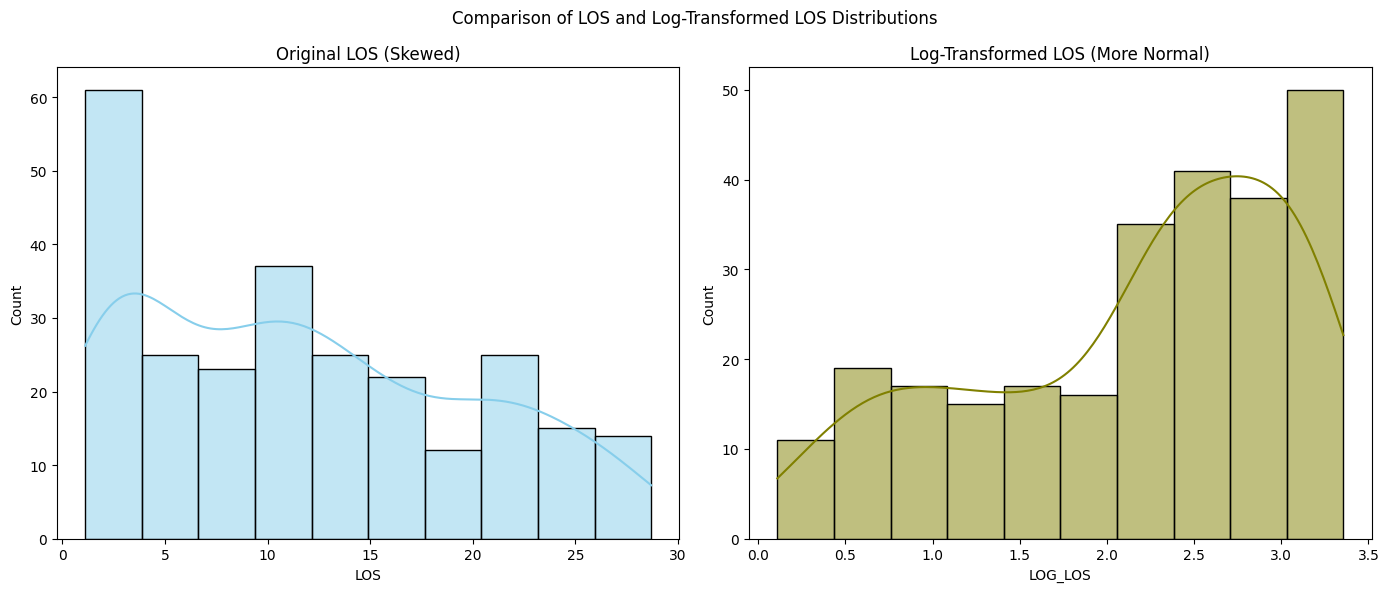

In [175]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_merged['LOG_LOS'] = np.log(df_merged['LOS'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Comparison of LOS and Log-Transformed LOS Distributions')

sns.histplot(df_merged['LOS'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Original LOS (Skewed)')

sns.histplot(df_merged['LOG_LOS'], kde=True, ax=axes[1], color='olive')
axes[1].set_title('Log-Transformed LOS (More Normal)')

plt.tight_layout()
plt.show()

In [176]:
# selected_small_id = 220271
# selected_mean_id =  284345
selected_big_id = 285837

icu_info = df_icustays[df_icustays['ICUSTAY_ID'] == selected_big_id]
# icu_info


In [177]:
starttime = pd.to_datetime(icu_info['INTIME'].iloc[0])
endtime = starttime + pd.Timedelta(hours=24)

# starttime, endtime

In [178]:
print(df_merged.shape)
df_merged.head()

(259, 15)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE,LOG_LOS
287,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.000000,False,False,False,False,True,0.109661
291,94937,162005,48283,280084,2107-01-18 11:11:21,1.1432,1,68.389459,0.066393,False,False,False,True,False,0.133831
244,63941,126602,48283,270748,2196-04-23 14:49:48,1.1496,0,74.917864,0.002738,False,False,False,True,False,0.139414
14,3078,147024,48283,272986,2175-12-09 15:03:51,1.1541,1,47.793977,0.021903,False,False,False,False,True,0.143321
29,5062,123244,48283,250261,2100-12-10 12:50:48,1.2110,1,71.835044,0.027379,False,False,False,False,True,0.191446


In [179]:
df_chart_events =  pd.read_csv(data_path + 'd_pneumonia.csv', low_memory=False) 
 
print(df_chart_events.shape)      
df_chart_events.head()

(986962, 15)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,170754,1709,127294,207018,220052,2118-01-04 12:15:00,2118-01-04 14:22:00,19783.0,124.0,124.0,mmHg,0.0,0.0,NaN,NaN
1,170755,1709,127294,207018,220210,2118-01-04 12:15:00,2118-01-04 14:22:00,19783.0,30.0,30.0,insp/min,0.0,0.0,NaN,NaN
2,170756,1709,127294,207018,220277,2118-01-04 12:15:00,2118-01-04 14:22:00,19783.0,96.0,96.0,%,0.0,0.0,NaN,NaN
3,170757,1709,127294,207018,220179,2118-01-04 12:20:00,2118-01-04 14:22:00,19783.0,148.0,148.0,mmHg,0.0,0.0,NaN,NaN
4,170758,1709,127294,207018,220180,2118-01-04 12:20:00,2118-01-04 14:22:00,19783.0,69.0,69.0,mmHg,0.0,0.0,NaN,NaN


In [180]:
# 1. Merge df_merged with CHARTEVENTS (left join to preserve all ICU stays)
df_merged_with_chartevents = pd.merge(
    df_merged,  # Key columns
    df_chart_events[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'VALUENUM','CHARTTIME','VALUEUOM']].drop_duplicates(),
    on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],
    how='left',
    indicator=True  # Adds a column '_merge' to show match status
)
# print(df_merged.columns)
print(df_merged_with_chartevents.shape)

# 2. Identify ICU stays with/without CHARTEVENTS
has_chartevents = df_merged_with_chartevents['_merge'] == 'both'
no_chartevents = df_merged_with_chartevents['_merge'] == 'left_only'

# 3. Get the lists of ICUSTAY_IDs
icu_with_data = df_merged_with_chartevents[has_chartevents]['ICUSTAY_ID'].unique()
icu_without_data = df_merged_with_chartevents[no_chartevents]['ICUSTAY_ID'].unique()

print(f"ICU stays WITH CHARTEVENTS data: {len(icu_with_data)}")
print(f"ICU stays WITHOUT CHARTEVENTS data: {len(icu_without_data)}")

df_merged_with_chartevents = df_merged_with_chartevents[df_merged_with_chartevents['_merge'] == 'both'].copy()

print(df_merged_with_chartevents.shape)

# df_merged_with_chartevents.head()

(834695, 20)
ICU stays WITH CHARTEVENTS data: 126
ICU stays WITHOUT CHARTEVENTS data: 133
(834562, 20)


(834562, 20)
(87861, 21)


<Axes: xlabel='NORMTIME', ylabel='Count'>

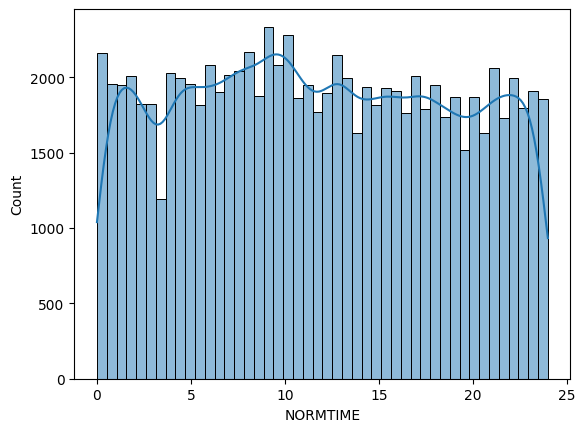

In [181]:
print(df_merged_with_chartevents.shape)
df_merged_with_chartevents['INTIME'] = pd.to_datetime(df_merged_with_chartevents['INTIME'])
df_merged_with_chartevents['CHARTTIME'] = pd.to_datetime(df_merged_with_chartevents['CHARTTIME'])

df_merged_with_chartevents.isnull().sum()

df_merged_with_chartevents['NORMTIME'] = (df_merged_with_chartevents['CHARTTIME'] - df_merged_with_chartevents['INTIME']).dt.total_seconds() / 3600
df_merged_with_chartevents = df_merged_with_chartevents[(df_merged_with_chartevents['NORMTIME'] <= 24) &
                                                         (df_merged_with_chartevents['NORMTIME'] >= 0)]
df_merged_with_chartevents.describe()

print(df_merged_with_chartevents.shape)

sns.histplot(df_merged_with_chartevents['NORMTIME'], kde=True)


<Axes: xlabel='NORMTIME', ylabel='Count'>

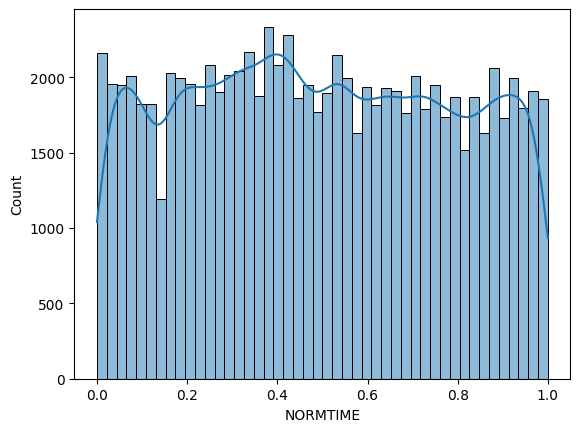

In [182]:
df_merged_with_chartevents['NORMTIME'] = df_merged_with_chartevents['NORMTIME'] / 24.0

sns.histplot(df_merged_with_chartevents['NORMTIME'], kde=True)

In [183]:
# icu_with_data

In [184]:
df_merged_with_chartevents.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE', 'ICUSTAY_ID', 'INTIME', 'LOS',
       'GENDER', 'AGE', 'ADMITIME', 'ETH_BLACK/AFRICAN AMERICAN',
       'ETH_HISPANIC OR LATINO', 'ETH_OTHER', 'ETH_UNKNOWN/NOT SPECIFIED',
       'ETH_WHITE', 'LOG_LOS', 'ITEMID', 'VALUENUM', 'CHARTTIME', 'VALUEUOM',
       '_merge', 'NORMTIME'],
      dtype='object')

<Axes: xlabel='AGE', ylabel='Count'>

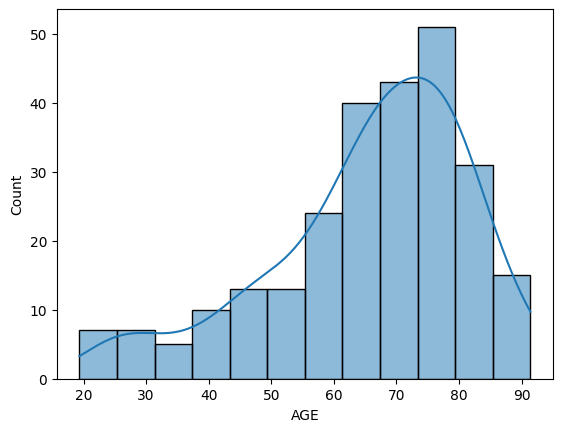

In [185]:
sns.histplot(df_merged['AGE'], kde=True)

In [186]:
# df_merged.describe().T

In [187]:
print(df_merged_with_chartevents.shape)
# df_merged_with_chartevents.drop(columns=['_merge','INTIME','CHARTTIME'],inplace=True)

df_merged_with_chartevents.head()

(87861, 21)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ICUSTAY_ID,INTIME,LOS,GENDER,AGE,ADMITIME,ETH_BLACK/AFRICAN AMERICAN,...,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE,LOG_LOS,ITEMID,VALUENUM,CHARTTIME,VALUEUOM,_merge,NORMTIME
0,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,...,False,False,True,0.109661,220277.0,94.0,2142-05-02 15:19:00,%,both,0.010903
1,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,...,False,False,True,0.109661,223751.0,160.0,2142-05-02 15:19:00,mmHg,both,0.010903
2,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,...,False,False,True,0.109661,223752.0,90.0,2142-05-02 15:19:00,mmHg,both,0.010903
3,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,...,False,False,True,0.109661,223761.0,98.0,2142-05-02 15:19:00,?F,both,0.010903
4,87980,110615,48283,243965,2142-05-02 15:03:18,1.1159,1,65.748118,0.0,False,...,False,False,True,0.109661,223769.0,100.0,2142-05-02 15:19:00,%,both,0.010903


In [188]:
df_merged_with_chartevents.describe().T

,count,mean,min,25%,50%,75%,max,std
SUBJECT_ID,87861.0,71301.160595,114.0,55570.0,89223.0,89223.0,99423.0,26174.623182
HADM_ID,87861.0,145691.328724,101117.0,134966.0,134966.0,164037.0,198412.0,22980.189669
ICUSTAY_ID,87861.0,269490.962065,200387.0,248514.0,286609.0,293675.0,299407.0,30057.507973
INTIME,87861,2173-02-24 18:56:50.097438720,2101-01-19 04:08:52,2148-10-30 16:20:12,2193-10-28 15:51:46,2197-08-08 13:36:31.000000512,2207-12-13 20:57:20,NaN
LOS,87861.0,12.197026,1.1159,9.83,13.137,13.137,28.688,5.456207
GENDER,87861.0,0.351294,0.0,0.0,0.0,1.0,1.0,0.477377
AGE,87861.0,68.029486,21.366872,64.786448,72.778234,72.778234,91.4,12.645562
ADMITIME,87861.0,0.004766,0.0,0.0,0.0,0.0,0.158795,0.017076
LOG_LOS,87861.0,2.347552,0.109661,2.285439,2.575433,2.575433,3.356479,0.645734
ITEMID,87861.0,220489.598673,39.0,220210.0,223835.0,224695.0,228444.0,22938.530324


In [189]:
df_merged_with_chartevents.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE', 'ICUSTAY_ID', 'INTIME', 'LOS',
       'GENDER', 'AGE', 'ADMITIME', 'ETH_BLACK/AFRICAN AMERICAN',
       'ETH_HISPANIC OR LATINO', 'ETH_OTHER', 'ETH_UNKNOWN/NOT SPECIFIED',
       'ETH_WHITE', 'LOG_LOS', 'ITEMID', 'VALUENUM', 'CHARTTIME', 'VALUEUOM',
       '_merge', 'NORMTIME'],
      dtype='object')

In [190]:
static_features = df_merged_with_chartevents.drop_duplicates(subset=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])[
    ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID','ADMITIME', 'AGE', 'GENDER', 
     'ETH_BLACK/AFRICAN AMERICAN', 'ETH_HISPANIC OR LATINO', 
     'ETH_OTHER', 'ETH_UNKNOWN/NOT SPECIFIED', 'ETH_WHITE','LOS', 'LOG_LOS']
]

static_features.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ADMITIME,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,ETH_WHITE,LOS,LOG_LOS
0,87980,110615,243965,0.000000,65.748118,1,False,False,False,False,True,1.1159,0.109661
263,94937,162005,280084,0.066393,68.389459,1,False,False,False,True,False,1.1432,0.133831
544,63941,126602,270748,0.002738,74.917864,0,False,False,False,True,False,1.1496,0.139414
862,43484,172124,210014,0.024641,76.251882,1,True,False,False,False,False,1.2523,0.224982
1150,26855,112153,200612,0.002738,66.260096,0,False,False,False,True,False,1.2891,0.253944


In [191]:
import pandas as pd
import numpy as np

# This function now correctly expects a list of IDs for the third argument.
# The 'features_df' (for mapping names) is now a separate, optional argument.
def create_feature_matrix(df_events, df_static, item_ids, features_df=None, agg_list=None):
    """
    Creates a feature matrix by combining static data with aggregated time-series features.
    This version correctly accepts a list of ITEMIDs and robustly flattens MultiIndex columns.

    Args:
        df_events (pd.DataFrame): Time-series data with 'SUBJECT_ID', 'ITEMID', 'VALUENUM', 'CHARTTIME'.
        df_static (pd.DataFrame): Static patient data with 'SUBJECT_ID'.
        item_ids (list): A Python list of ITEMIDs to use for feature generation.
        features_df (pd.DataFrame, optional): For mapping ITEMID to readable names. 
                                               Must have 'ITEMID' and 'item_name' columns. Defaults to None.
        agg_list (list, optional): Aggregations to compute. Defaults to ['mean', 'std', 'count', 'range', 'trend'].

    Returns:
        pd.DataFrame: Combined static + aggregated features, with NaN filled as 0.
    """
    if agg_list is None:
        agg_list = ['mean', 'std', 'count', 'range', 'trend']

    # 1. Filter relevant ITEMIDs from the provided list
    df_filtered = df_events[df_events['ITEMID'].isin(item_ids)].copy()
    df_filtered['CHARTTIME'] = pd.to_datetime(df_filtered['CHARTTIME'])

    # 2. Define aggregation calculations (no changes here)
    def calculate_aggregated_features(group):
        vals = group['VALUENUM']
        count = vals.count()
        features = {}
        for agg in agg_list:
            features[agg] = 0
        if count == 0:
            return pd.Series(features)
        if 'count' in agg_list: features['count'] = count
        if 'mean' in agg_list: features['mean'] = vals.mean()
        if 'std' in agg_list: features['std'] = vals.std() if count > 1 else 0
        if 'range' in agg_list: features['range'] = vals.max() - vals.min() if count > 1 else 0
        if 'trend' in agg_list and count > 1:
            group = group.sort_values('CHARTTIME')
            time_in_hours = (group['CHARTTIME'] - group['CHARTTIME'].iloc[0]).dt.total_seconds() / 3600.0
            valid_indices = time_in_hours.notna() & vals.notna()
            if valid_indices.sum() > 1:
                slope = np.polyfit(time_in_hours[valid_indices], vals[valid_indices], 1)[0]
                features['trend'] = slope if np.isfinite(slope) else 0
        return pd.Series(features)

    # 3. Compute aggregations
    item_stats = (
        df_filtered.groupby(['SUBJECT_ID', 'ITEMID'])
        .apply(calculate_aggregated_features)
        .unstack(fill_value=0)
    )
    
    # 4. Flatten MultiIndex columns (Robust Fix)
    if isinstance(item_stats.columns, pd.MultiIndex):
        if features_df is not None:
            # Ensure data types match for mapping
            features_df['ITEMID'] = features_df['ITEMID'].astype(int)
            itemid_to_label = dict(zip(features_df['ITEMID'], features_df['item_name']))
            item_stats.columns = [
                f"{agg}_{itemid_to_label.get(int(itemid), f'ITEM_{itemid}')}"
                for agg, itemid in item_stats.columns
            ]
        else: # If no features_df is provided, use default names
            item_stats.columns = [
                f"{agg}_ITEM_{itemid}" for agg, itemid in item_stats.columns
            ]

    item_stats = item_stats.reset_index()

    # 5. Merge with static data
    model_data = pd.merge(
        df_static,
        item_stats,
        on='SUBJECT_ID',
        how='left'
    ).fillna(0)

    return model_data

In [192]:
top30_features_df = pd.read_csv(data_path + 'items_appearance_pneumonia.csv')

top30_features_df.head()

,rank,ITEMID,item_name,VALUEUOM,stay_count
0,1,220645.0,Sodium (serum),mEq/L,135
1,2,220615.0,Creatinine,mg/dL,135
2,3,220602.0,Chloride (serum),mEq/L,135
3,4,225624.0,BUN,mg/dL,135
4,5,227443.0,HCO3 (serum),mEq/L,135


In [193]:
top30_features = top30_features_df[top30_features_df['rank'] <= 32]['ITEMID'].to_list()

print('The number of items is: ', len(top30_features))

The number of items is:  32


In [194]:
model_data_full = create_feature_matrix(
    df_merged_with_chartevents,
    static_features,
    top30_features, # The list of ITEMIDs
    features_df=top30_features_df # The dataframe for naming (optional)
)
print(model_merged_with_chart.shape)
model_data_full.head()

/var/folders/3h/2yy19zsd15q4cksyddkdpd_00000gn/T/ipykernel_11598/4268334774.py:54: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_aggregated_features)


NameError: name 'model_merged_with_chart' is not defined

In [ ]:
model_data_full.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ADMITIME', 'AGE', 'GENDER',
       'ETH_BLACK/AFRICAN AMERICAN', 'ETH_HISPANIC OR LATINO', 'ETH_OTHER',
       'ETH_UNKNOWN/NOT SPECIFIED',
       ...
       'trend_Calcium non-ionized', 'trend_Phosphorous',
       'trend_TCO2 (calc) Arterial', 'trend_SpO2 Desat Limit',
       'trend_Anion gap', 'trend_Potassium (serum)', 'trend_HCO3 (serum)',
       'trend_Platelet Count', 'trend_Prothrombin time', 'trend_INR'],
      dtype='object', length=173)

In [ ]:
model_data_full.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ADMITIME,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,...,trend_Calcium non-ionized,trend_Phosphorous,trend_TCO2 (calc) Arterial,trend_SpO2 Desat Limit,trend_Anion gap,trend_Potassium (serum),trend_HCO3 (serum),trend_Platelet Count,trend_Prothrombin time,trend_INR
0,87980,110615,243965,0.000000,65.748118,1,False,False,False,False,...,-0.053503,0.000000,0.000000,-2.495307e-15,-0.152866,-0.061146,-0.076433,0.305732,0.000000,0.000000
1,94937,162005,280084,0.066393,68.389459,1,False,False,False,True,...,-0.000827,-0.007464,-0.075559,0.000000e+00,-0.012288,-0.000893,0.003193,-0.330480,-0.002616,-0.000348
2,63941,126602,270748,0.002738,74.917864,0,False,False,False,True,...,0.000000,0.000000,0.000000,2.405895e-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,43484,172124,210014,0.024641,76.251882,1,True,False,False,False,...,-0.000136,-0.000782,0.045344,9.633185e-17,-0.016617,-0.000427,0.034211,0.077485,0.000943,-0.000307
4,26855,112153,200612,0.002738,66.260096,0,False,False,False,True,...,0.000000,0.000000,0.000000,-7.964538e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
from sklearn.feature_selection import VarianceThreshold
# only works on numerical features
selector = VarianceThreshold(threshold=0.01)  # drop features with <1% variance

non_numerical_feature_cols = ['SUBJECT_ID','HADM_ID','ICUSTAY_ID','LOG_LOS']

feature_cols = [col for col in model_data_full.columns if col not in non_numerical_feature_cols]

features_df = model_data_full[feature_cols]
selector.fit(features_df)

kept_cols = features_df.columns[selector.get_support()]

print(f"Original number of features: {len(feature_cols)}")
print(f"Number of features kept: {len(kept_cols)}")

final_cols_to_keep = non_numerical_feature_cols + kept_cols.tolist()
df_selected = model_data_full[final_cols_to_keep]
# df_selected = model_data_full
print("\nShape of the new DataFrame:", df_selected.shape)
print("\nFirst 5 rows of the new DataFrame with selected features:")
# print(df_selected.head())

Original number of features: 169
Number of features kept: 154

Shape of the new DataFrame: (126, 158)

First 5 rows of the new DataFrame with selected features:


In [ ]:
dropped_cols_mask = ~selector.get_support()
dropped_cols = features_df.columns[dropped_cols_mask]
# Dropped columns
dropped_cols

Index(['ADMITIME', 'std_PH (Arterial)', 'range_PH (Arterial)',
       'trend_Hemoglobin', 'trend_O2 saturation pulseoxymetry',
       'trend_Creatinine', 'trend_Magnesium',
       'trend_O2 Saturation Pulseoxymetry Alarm - High',
       'trend_O2 Saturation Pulseoxymetry Alarm - Low', 'trend_PH (Arterial)',
       'trend_Resp Alarm - Low', 'trend_Calcium non-ionized',
       'trend_Phosphorous', 'trend_Potassium (serum)', 'trend_INR'],
      dtype='object')

Generating heatmap for features before correlation-based removal...


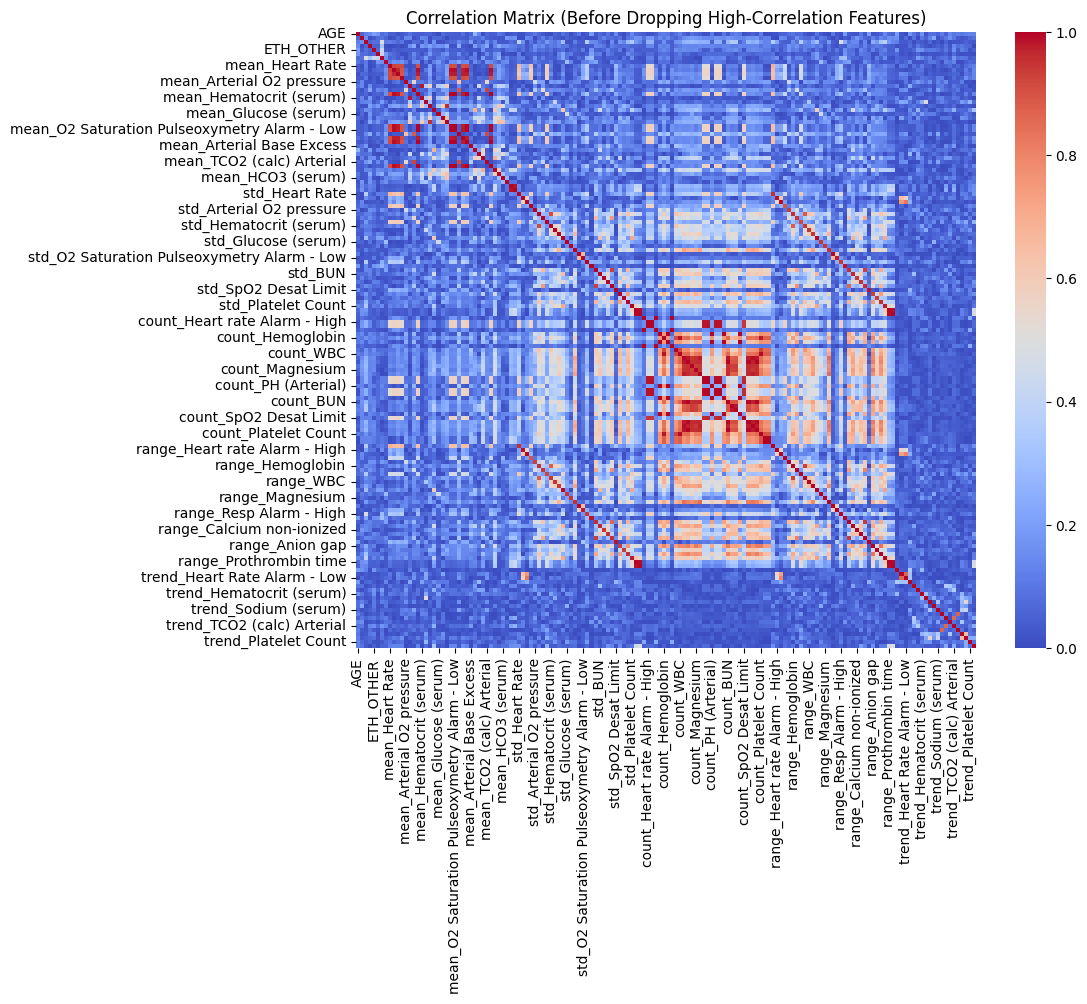

In [ ]:
X = df_selected.drop(columns=non_numerical_feature_cols)

corr_matrix = X.corr().abs()

print("Generating heatmap for features before correlation-based removal...")

plt.figure(figsize=(10, 8))  # Adjust size as needed for readability
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False) # annot=True can be used for smaller matrices
plt.title('Correlation Matrix (Before Dropping High-Correlation Features)')
plt.show()


In [ ]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print(f"Number of features to drop due to high correlation: {len(to_drop)}")
print("Columns being dropped:", to_drop)


Number of features to drop due to high correlation: 72
Columns being dropped: ['mean_Heart rate Alarm - High', 'mean_Heart Rate Alarm - Low', 'mean_Respiratory Rate', 'mean_O2 saturation pulseoxymetry', 'mean_Hematocrit (serum)', 'mean_Sodium (serum)', 'mean_O2 Saturation Pulseoxymetry Alarm - High', 'mean_O2 Saturation Pulseoxymetry Alarm - Low', 'mean_Resp Alarm - High', 'mean_Resp Alarm - Low', 'mean_TCO2 (calc) Arterial', 'mean_SpO2 Desat Limit', 'mean_INR', 'std_Hematocrit (serum)', 'std_TCO2 (calc) Arterial', 'std_INR', 'count_Heart Rate Alarm - Low', 'count_Respiratory Rate', 'count_Arterial CO2 Pressure', 'count_O2 saturation pulseoxymetry', 'count_Hematocrit (serum)', 'count_WBC', 'count_Creatinine', 'count_Glucose (serum)', 'count_Magnesium', 'count_Sodium (serum)', 'count_O2 Saturation Pulseoxymetry Alarm - High', 'count_O2 Saturation Pulseoxymetry Alarm - Low', 'count_PH (Arterial)', 'count_Resp Alarm - High', 'count_Resp Alarm - Low', 'count_Arterial Base Excess', 'count_B

In [ ]:
df_final_selected_copy = df_selected.drop(columns=to_drop)
df_final_selected = df_selected

print(f"\nFinal number of features: {df_final_selected.shape[1] - len(non_numerical_feature_cols)}")
print("Shape of the final DataFrame:", df_final_selected.shape)
print("\nFirst 5 rows of the final DataFrame:")
df_final_selected.head()


Final number of features: 154
Shape of the final DataFrame: (126, 158)

First 5 rows of the final DataFrame:


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,LOG_LOS,AGE,GENDER,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC OR LATINO,ETH_OTHER,ETH_UNKNOWN/NOT SPECIFIED,...,trend_Sodium (serum),trend_Resp Alarm - High,trend_Arterial Base Excess,trend_BUN,trend_TCO2 (calc) Arterial,trend_SpO2 Desat Limit,trend_Anion gap,trend_HCO3 (serum),trend_Platelet Count,trend_Prothrombin time
0,87980,110615,243965,0.109661,65.748118,1,False,False,False,False,...,-0.305732,-8.317690e-16,0.000000,-0.382166,0.000000,-2.495307e-15,-0.152866,-0.076433,0.305732,0.000000
1,94937,162005,280084,0.133831,68.389459,1,False,False,False,True,...,0.010028,4.331593e-03,-0.118915,-0.038307,-0.075559,0.000000e+00,-0.012288,0.003193,-0.330480,-0.002616
2,63941,126602,270748,0.139414,74.917864,0,False,False,False,True,...,0.000000,3.165939e-01,0.000000,0.000000,0.000000,2.405895e-15,0.000000,0.000000,0.000000,0.000000
3,43484,172124,210014,0.224982,76.251882,1,True,False,False,False,...,-0.021909,-1.405424e-02,0.040226,-0.013226,0.045344,9.633185e-17,-0.016617,0.034211,0.077485,0.000943
4,26855,112153,200612,0.253944,66.260096,0,False,False,False,True,...,0.000000,-5.988390e-02,0.000000,0.000000,0.000000,-7.964538e-16,0.000000,0.000000,0.000000,0.000000


- Isolate Features (X): We start with df_variance_selected, the DataFrame that has already been filtered for low variance. We create X which contains only the feature columns from this set.
- Correlation Matrix: We compute the correlation matrix for X and take the absolute value, as we're interested in the strength of the correlation, not its direction (positive or negative).
- Upper Triangle: The line np.triu(...) creates a mask for the upper triangle of the matrix (everything above the main diagonal). We do this because a correlation matrix is symmetrical (corr(A,B) is the same as corr(B,A)), and we only need to check each pair of features once to avoid redundancy.
- Find Columns to Drop: We iterate through the columns of our upper-triangle view. If any value in a column is greater than our threshold (0.9), we add that column's name to our to_drop list. This effectively keeps one feature from each highly correlated pair and flags the other for removal.
- Create Final DataFrame: We drop the columns in the to_drop list from df_variance_selected to produce our final, cleaned dataset df_final_selected.


Generating heatmap for the final set of features...


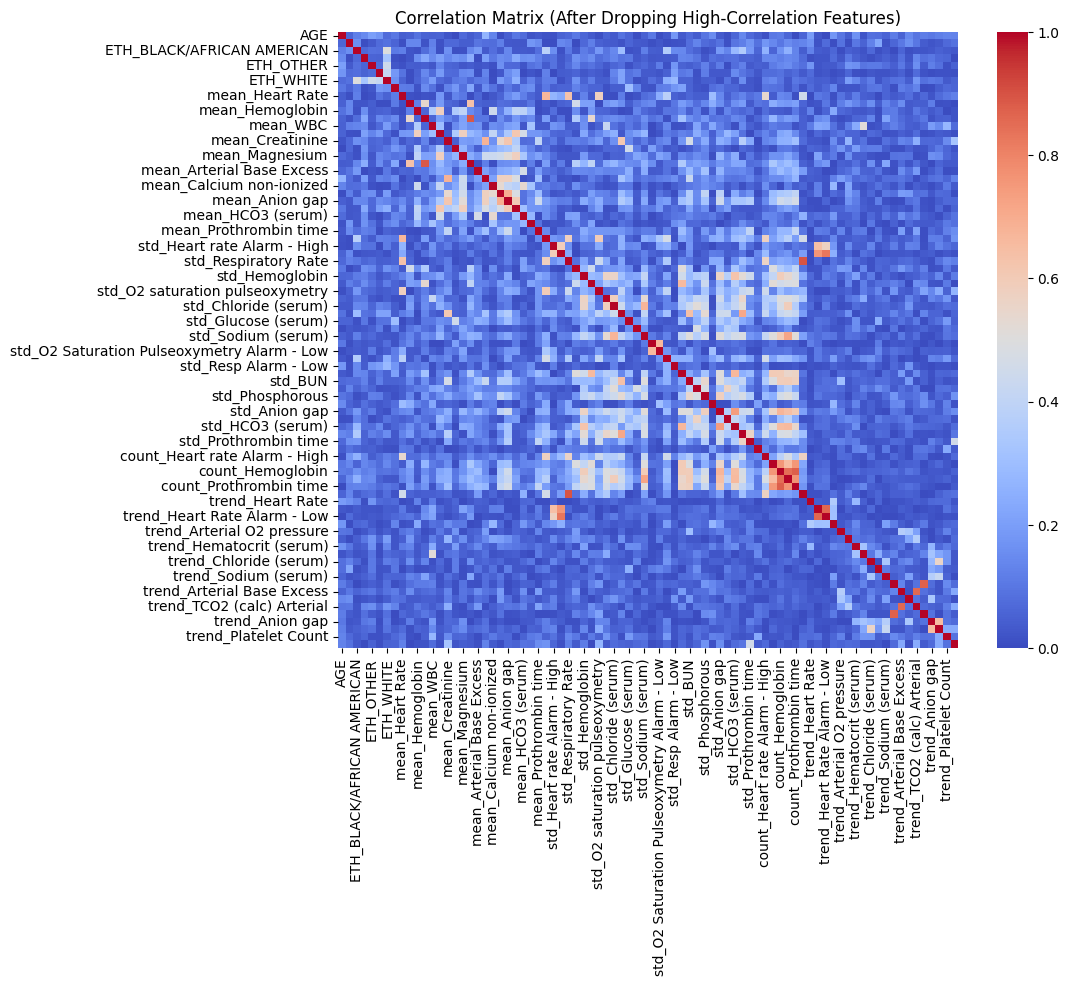

In [ ]:
final_features = df_final_selected_copy.drop(columns=non_numerical_feature_cols)

# Calculate the new correlation matrix
final_corr_matrix = final_features.corr().abs()

print("\nGenerating heatmap for the final set of features...")

plt.figure(figsize=(10, 8)) # Can be a bit smaller as there are fewer features
sns.heatmap(final_corr_matrix, cmap='coolwarm', annot=False, vmin=0, vmax=1)
plt.title('Correlation Matrix (After Dropping High-Correlation Features)')
plt.show()


In [ ]:
df_final_selected.shape

(126, 158)

In [195]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

def filter_low_importance_features(df, target_column, group_column=None, threshold=0.01, n_splits=5):
    y = df[target_column]
    X = df.drop(columns=[target_column,'HADM_ID','SUBJECT_ID','ICUSTAY_ID','LOG_LOS'])
    
    groups = df[group_column] if group_column else np.arange(len(df))

    # Initialize GroupKFold
    gkf = GroupKFold(n_splits=n_splits)
    model = XGBRegressor(n_estimators=1000, early_stopping_rounds=10, eval_metric='rmse', verbosity=0)

    # Use first fold for early stopping
    train_idx, val_idx = next(gkf.split(X, y, groups))
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Compute permutation importance
    result = permutation_importance(model, X_val, y_val, n_repeats=5, scoring='neg_root_mean_squared_error', random_state=42)
    importances = result.importances_mean

    # Compute relative importances
    relative_importances = importances / np.sum(importances)

    # Select features with >= 1% contribution
    important_features = X.columns[relative_importances >= threshold]
    print(f"Retaining {len(important_features)} features out of {X.shape[1]}")

    return df[important_features.tolist() + [target_column]]

# Example usage:
df_final_selected = filter_low_importance_features(df_final_selected, target_column='LOS', group_column='SUBJECT_ID',threshold = 0.01)

Retaining 8 features out of 153


In [ ]:
df_final_selected.head()

,mean_Heart Rate,mean_Heart Rate Alarm - Low,mean_Arterial O2 pressure,mean_WBC,mean_PH (Arterial),mean_Calcium non-ionized,mean_Phosphorous,mean_Platelet Count,count_Resp Alarm - High,range_Arterial Base Excess,trend_Heart rate Alarm - High,trend_Heart Rate Alarm - Low,trend_Resp Alarm - High,LOS
0,75.259259,60.000000,0.000000,8.55,0.00000,9.350000,3.700000,194.0,3.0,0.0,-2.834508e-15,-1.417254e-15,-5.950044e-16,1.1159
1,65.063830,55.714286,283.142857,13.60,7.31625,8.900000,5.800000,189.5,7.0,6.0,-1.894338e-02,-7.342868e-03,4.331593e-03,1.1432
2,97.257143,60.000000,0.000000,17.00,0.00000,9.200000,3.200000,526.0,3.0,0.0,3.165939e-01,2.007481e-15,3.165939e-01,1.1496
3,83.189873,52.500000,142.600000,7.74,7.47500,7.966667,3.583333,194.0,8.0,14.0,2.399951e-16,1.356547e-02,-1.405424e-02,1.2523
4,75.478261,50.000000,0.000000,3.10,0.00000,8.500000,3.100000,211.0,4.0,0.0,-3.671567e-16,3.191842e-16,-5.988390e-02,1.2891


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

df_perm_selected = df_final_selected
# --- 1. Prepare Data ---
# Assume 'df_perm_selected' is your final DataFrame
X = df_perm_selected.drop(columns='LOS')
print(X.columns)
y = df_perm_selected['LOS']

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. Define GridSearchCV ---
params = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'reg_alpha': [0.1]
}

xgb = XGBRegressor(random_state=42)
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=42)

print("Running GridSearchCV to find the best model...")
model = GridSearchCV(estimator=xgb, param_grid=params, cv=cv_splitter, scoring='neg_root_mean_squared_error', n_jobs=-1)
model.fit(X_train, y_train)
print("GridSearchCV complete.")

# --- 3. Evaluate the Best Model on the Test Set ---
best_model = model.best_estimator_

# Use the best model to predict on the unseen test set
predictions_log = best_model.predict(X_test)

# Convert both the predictions and the true test labels back to days
predictions_days = (predictions_log)
y_test_days = (y_test)

# --- Calculate all three metrics on the original 'days' scale ---
final_mae = mean_absolute_error(y_test_days, predictions_days)
final_mse = mean_squared_error(y_test_days, predictions_days)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test_days, predictions_days)

# --- 4. Report All Results ---
print(f"\nBest parameters found: {model.best_params_}")
print("\n--- Final Model Performance on Hold-Out Test Set ---")
print(f"Mean Absolute Error (MAE): {final_mae:.4f} days")
print(f"Root Mean Squared Error (RMSE): {final_rmse:.4f} days")
print(f"R-squared (R²): {final_r2:.4f}")

Index(['mean_Heart Rate', 'mean_Heart Rate Alarm - Low',
       'mean_Arterial O2 pressure', 'mean_WBC', 'mean_PH (Arterial)',
       'mean_Calcium non-ionized', 'mean_Phosphorous', 'mean_Platelet Count',
       'count_Resp Alarm - High', 'range_Arterial Base Excess',
       'trend_Heart rate Alarm - High', 'trend_Heart Rate Alarm - Low',
       'trend_Resp Alarm - High'],
      dtype='object')
Running GridSearchCV to find the best model...
GridSearchCV complete.

Best parameters found: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1}

--- Final Model Performance on Hold-Out Test Set ---
Mean Absolute Error (MAE): 6.2824 days
Root Mean Squared Error (RMSE): 6.9971 days
R-squared (R²): -0.1748


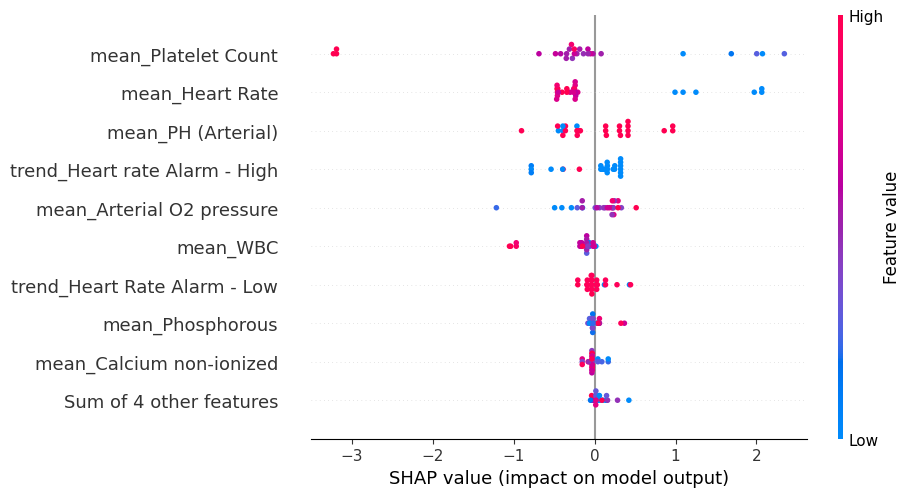

In [ ]:
import shap
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)